In [1]:
import datetime
import pytz
import copy
import glob
import os
import math 
from enum import IntEnum

import pandas as pd
import numpy as np
from dotenv import load_dotenv

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import mplfinance as mpf
from stock_indicators import indicators
from stock_indicators.indicators.common.quote import Quote

# Загрузка данных

In [2]:
#path = "data\\2024-GDM4"
#path = "data\\2024-GDU4"
path = "data\\2025-GDM5"
#path = "data\\2025-SBER"
#path = "data\\2025-MXM5"

all_files = glob.glob(os.path.join(path, "*.csv"))
ticker_data = pd.concat((pd.read_csv(f, 
                            delimiter=";",
                            usecols=[1,2,3,4,5,6], 
                            names=['UTC', 'open', 'close','high','low','volume'],
                            dtype = {'UTC': 'str', 
                                      'open': 'float', 
                                      'close': 'float', 
                                      'high': 'float',
                                      'low': 'float',
                                      'volume': 'int'},
                            parse_dates=['UTC']
                           ) 
                for f in all_files), ignore_index=True)
ticker_data.index = pd.DatetimeIndex(ticker_data['UTC'])
ticker_data.drop(['UTC'], axis=1, inplace=True)

In [3]:
len(ticker_data)

52735

In [4]:
ticker_data

,open,close,high,low,volume
UTC,,,,,
2025-03-03 05:59:00+00:00,2932.3,2936.0,2936.0,2932.3,25
2025-03-03 06:00:00+00:00,2936.3,2939.0,2939.0,2936.3,69
2025-03-03 06:01:00+00:00,2938.8,2938.8,2938.8,2938.8,1
2025-03-03 06:02:00+00:00,2938.6,2938.7,2938.7,2938.6,8
2025-03-03 06:03:00+00:00,2938.6,2938.8,2938.8,2938.6,11
...,...,...,...,...,...
2025-05-30 20:45:00+00:00,3286.9,3286.5,3286.9,3286.5,105
2025-05-30 20:46:00+00:00,3286.9,3286.6,3286.9,3286.6,32
2025-05-30 20:47:00+00:00,3286.8,3286.3,3287.0,3286.3,102


# Описание стратегии

In [5]:
class StrategyCommand(IntEnum):
    BEAR_GO = -2
    BEAR_HOLD = -1
    CLOSE = 0
    BULL_HOLD = 1
    BULL_GO = 2

In [6]:
class StrategyInterface:

    # размер окна данных, который анализирует стратегия
    frame_size = 22
    
    def next(self, data):
        raise Exception("next method not implemented") 
    

In [7]:
class SimpleStrategy(StrategyInterface):
    
    # конфигурация
    #frame_size = 22
    frame_size = 120
    fractal_in_enabled  = True
    fractal_out_enabled = True
    fractal_size = 5
    
    def __init__(self):
        
        return

    # Расчет индикаторов
    def calc_indicators(self, data ):
        quotes = [Quote(d,o,h,l,c,v) for d,o,h,l,c,v in zip(data.index, data['open'], data['high'], data['low'], data['close'], data['volume'])]
        alligator = indicators.get_alligator(quotes)
        fractal = indicators.get_fractal(quotes, self.fractal_size)
        result = data.copy()
        result["jaw"] = [ a.jaw for a in alligator]
        result["teeth"] = [ a.teeth for a in alligator]
        result["lips"] = [ a.lips for a in alligator]
        result["fractal_bear"] = [ f.fractal_bear if f.fractal_bear != None else np.nan for f in fractal]
        result["fractal_bull"] = [ f.fractal_bull if f.fractal_bull != None else np.nan for f in fractal]
        
        return result

    # helper
    def get_params(self,data):
        
        index = data.tail(1).index[0]
        prev_index = data.tail(2).index[0]
        fractal_index = data.tail(self.fractal_size+1).index[0]
        return (
                index,
                data.at[index, 'open'], 
                data.at[index, 'close'],
                data.at[index, 'high'],
                data.at[index, 'low'],
                data.at[index, 'volume'],

                data.at[index, 'jaw'  ] if data.at[index, 'jaw'  ] != None else np.nan,
                data.at[index, 'teeth'] if data.at[index, 'teeth'] != None else np.nan,
                data.at[index, 'lips' ] if data.at[index, 'lips' ] != None else np.nan,

                data.at[prev_index, 'jaw'  ] if data.at[prev_index, 'jaw'  ] != None else np.nan,
                data.at[prev_index, 'teeth'] if data.at[prev_index, 'teeth'] != None else np.nan,
                data.at[prev_index, 'lips' ] if data.at[prev_index, 'lips' ] != None else np.nan,

                data.at[fractal_index, 'fractal_bear'],
                data.at[fractal_index, 'fractal_bull']
           )
    
    # обработка шага стратегии
    def next(self, data):

        
        # инициализация локальных переменных
        indicators = self.calc_indicators(data)
        (
            time,   open_,  close,   high,   low,   volume,   
            jaw,   teeth,   lips,   
            prev_jaw,   prev_teeth,   prev_lips,
            fractal_bear,   fractal_bull
        )   = self.get_params(indicators)

        command = StrategyCommand.CLOSE
        stop_loss = jaw
        last_row = indicators.tail(1).copy()
        last_row.loc[ last_row.index[0], 'fractal_bull'] = fractal_bull 
        last_row.loc[ last_row.index[0], 'fractal_bear'] = fractal_bear
        
        # прерываем исполнение, если недостаточно данных
        if ( math.isnan(jaw) or 
             math.isnan(teeth) or 
             math.isnan(lips) or
             volume == 0 
            #or len(indicators.index) < self.frame_size
           ):
            return command, stop_loss, last_row
        
        #Определяем значение команды 
        # проверки на быка
        # проверяем главное условие аллигатора
        if   ( close > lips and lips > teeth and lips > jaw):
            command = StrategyCommand.BULL_HOLD
            stop_loss = close - 2*(1.6)
                
            if(
                # проверяем, что условие наступило только на текущем баре, а не сохраняется уже давно
                (lips >= low  or not (prev_lips > prev_teeth and prev_lips > prev_jaw) or math.isnan(prev_jaw))
                
                # проверяем доп. условие входа по пробитию уровня, чтобы отсечь мелкие тренды
                and (
                    not self.fractal_in_enabled 
                    or (
                        indicators['fractal_bear'].sum() > 0 
                        and np.nanmax(indicators['fractal_bear']) < close
                    )
                )
            ):    
                command = StrategyCommand.BULL_GO

        #проверки на медведя
        # проверяем главное условие аллигатора
        elif ( close < lips and lips < teeth and lips < jaw ):
            command = StrategyCommand.BEAR_HOLD
            stop_loss = close + 2*(1.6)
                
            if (
                # проверяем, что условие наступило только на текущем баре, а не сохраняется уже давно
                (lips <= high or not (prev_lips < prev_teeth and prev_lips < prev_jaw) or math.isnan(prev_jaw))
                
                # проверяем доп. условие входа по пробитию уровня, чтобы отсечь мелкие тренды
                and (
                    not self.fractal_in_enabled 
                    or (
                        indicators['fractal_bull'].sum() > 0 
                        and np.nanmin(indicators['fractal_bull']) > close
                    )
                )
            ):
                command = StrategyCommand.BEAR_GO
            
        # проверка на выход из позиции по фракталу
        if (
            #прерывание быка по медвежему фракталу
            (
                (command == StrategyCommand.BULL_GO or command == StrategyCommand.BULL_HOLD)
                and not math.isnan(fractal_bear) and self.fractal_out_enabled
            )
            #прерыване медведя по бычьему фракталу
            or (
                (command == StrategyCommand.BEAR_GO or command == StrategyCommand.BEAR_HOLD)
                and not math.isnan(fractal_bull) and self.fractal_out_enabled
            )   
        ):
            command = StrategyCommand.CLOSE

        return command, stop_loss, last_row

In [8]:
# стратегия для эмуляции результатов работы бота в бэктесте

class SandboxResultStrategy(StrategyInterface):
    
    # конфигурация
    file_path = 'data\\SandboxResults\\GDM5_sandbox_result_2025-05-31.csv'
    sandbox_commands = None
    source_strategy = None
    
    def __init__(self, source_strategy):

        self.frame_size = source_strategy.frame_size
        self.source_strategy = source_strategy
        
        self.sandbox_commands =  pd.read_csv(self.file_path, delimiter=";", dtype = {'UTC': 'str', 'command': 'int'}, parse_dates=['UTC'])
        self.sandbox_commands.index = pd.DatetimeIndex(self.sandbox_commands['UTC'])
        self.sandbox_commands.drop(['UTC'], axis=1, inplace=True)
        
        return

    
    # обработка шага стратегии
    def next(self, data):

        command, stop_loss, last_row = self.source_strategy.next(data)

        # определяем значение команды по логу результатов на песочнице
        dt = last_row.index[0]
        sandbox_commands_lr = self.sandbox_commands[:dt].tail(1)
        sc_command = sandbox_commands_lr['command'].iloc[0]
        if dt - sandbox_commands_lr.index[0] < datetime.timedelta(minutes=2):
            command = sc_command
        else:
            command = StrategyCommand.CLOSE
        return command, stop_loss, last_row
        

# Моделирование торговли

In [9]:
processig_data = ticker_data

#2024-GDM4
#processig_data = ticker_data['2024-03-01 00:00:00':'2024-06-01 00:00:00']
#processig_data = ticker_data['2024-05-03 00:00:00':'2024-05-09 00:00:00']

#2024-GDU4
#processig_data = ticker_data['2024-06-01 00:00:00':'2024-09-01 00:00:00']
#processig_data = ticker_data['2024-08-04 00:00:00':'2024-08-07 00:00:00']

#2025-GDM5
processig_data = ticker_data
#processig_data = ticker_data['2025-05-28 00:00:00':'2025-05-31 00:00:00']

#2025-SBER
#processig_data = ticker_data

#2025-MXM5
#processig_data = ticker_data

In [10]:
len(processig_data)

52735

In [12]:
comission = 0.01 * 0.05 # 0.05% процент комиссии от сделки

points = 0      # количесво выйграных пунктов цены
position = 0    # количество преобретенного инструмента
enter_price = 0
stop_loss = 0
bull_deals = 0
bear_deals = 0
rows = []
points_log = []
bear_stop_loss = []
bull_stop_loss = []
no_stop_loss   = []
deals_in  = []  # значения для грфика входов в сделки
deals_out = []  # знечения для графика выходов из сделок

end_stock_time = datetime.time(hour=21)
end_deals_before   = (datetime.datetime.combine(datetime.date(1,1,1),end_stock_time) + datetime.timedelta(hours=-1   )).time()
close_deals_before = (datetime.datetime.combine(datetime.date(1,1,1),end_stock_time) + datetime.timedelta(minutes=-10)).time()

# подготавливаем данные по дням
days_data = [group[1] for group in processig_data.groupby(processig_data.index.date)]

# запускаем цикл по дням

strategy = SimpleStrategy()
#strategy = SandboxResultStrategy(SimpleStrategy())
for day_data in days_data:
    bull_deals_day = 0
    bear_deals_day = 0
    
    # эмитация торговли внутри дня
    for index in day_data.index:
        target_loc = day_data.index.get_loc(index)
        start_loc = max(0, target_loc - strategy.frame_size)
        curient_frame = day_data.iloc[start_loc:target_loc + 1]
        open_   = curient_frame['open' ].iloc[-1]
        low     = curient_frame['low'  ].iloc[-1]
        high    = curient_frame['high' ].iloc[-1]
        close   = curient_frame['close'].iloc[-1]
        
        # значение для грфика входов в сделки
        deal_in = np.nan
        
        # знечение для графика выходов из сделок
        deal_out= np.nan

        # выход по stoploss
        if( position > 0 and (
                stop_loss > low 
                and enter_price*(1+comission) < close  # stoploss срабатывает только если мы уже вышли в безубыточность
            ) 
        ):
            position = 0 
            points += stop_loss - enter_price - comission*stop_loss
            deal_out = stop_loss
        elif( position < 0 and ( 
                stop_loss < high
                and enter_price*(1-comission) > close  # stoploss срабатывает только если мы уже вышли в безубыточность
            ) 
        ):
            position = 0 
            points += enter_price - stop_loss - comission*stop_loss
            deal_out = stop_loss
        
        # получаем команду от стратегии
        command, new_stop_loss, row = strategy.next(curient_frame)
        
        # закрываем старые позиции
        # закрываем быка
        if( position > 0):
            if (
                command < StrategyCommand.CLOSE                                           # если ещё не вышли в безубыточность
                or enter_price*(1+comission) < close and command == StrategyCommand.CLOSE # если уже вышли в безубыточность
                or index.time() > close_deals_before                                      # если биржа скоро закроется
            ):
                points += close - enter_price - comission*close
                position = 0 
                deal_out = close
            else:
                stop_loss = max(new_stop_loss, stop_loss)
        
        # закрываем медведя
        elif( position < 0):  
            if (
                command > StrategyCommand.CLOSE                                           # если ещё не вышли в безубыточность
                or enter_price*(1-comission) > close and command == StrategyCommand.CLOSE # если уже вышли в безубыточность
                or index.time() > close_deals_before                                      # если биржа скоро закроется
            ):
                points += enter_price - close - comission*close
                position = 0 
                deal_out = close
            else:
               stop_loss = min(new_stop_loss, stop_loss) 

        # Открываем новые позиции
        if ( position == 0 ):
            if(   command == StrategyCommand.BULL_GO  and index.time() < end_deals_before ):
                enter_price = close
                points -= comission*close
                position = 1
                stop_loss = new_stop_loss
                deal_in = close
                bull_deals_day += 1
            elif( command == StrategyCommand.BEAR_GO and index.time() < end_deals_before ):
                enter_price = close
                points -= comission*close
                position = -1
                stop_loss = new_stop_loss
                deal_in = close
                bear_deals_day += 1

        # заносим промежуточные параметры в массивы
        rows += [row]
        points_log += [points]
        bull_stop_loss += [ stop_loss if position >  0 else np.nan ]
        bear_stop_loss += [ stop_loss if position <  0 else np.nan ]
        no_stop_loss   += [ row['lips'].iloc[0] if position == 0 else np.nan ]
        deals_in  += [deal_in]
        deals_out += [deal_out]

    bull_deals += bull_deals_day
    bear_deals += bear_deals_day
    
    #выводим результаты на конец очереднго дня
    print(day_data.index[0].date().isoformat(), 
          "bars:", len(day_data.index), 
          "points:", points, 
          "bull_deals_day:", bull_deals_day, 
          "bear_deals_day:", bear_deals_day)

processed_data = pd.concat(rows)
processed_data['points'        ] = points_log
processed_data['bull_stop_loss'] = bull_stop_loss
processed_data['bear_stop_loss'] = bear_stop_loss
processed_data['no_stop_loss'  ] =   no_stop_loss
processed_data['deals_in'      ] = deals_in
processed_data['deals_out'     ] = deals_out

2025-03-03 bars: 568 points: -24.74655000000036 bull_deals_day: 5 bear_deals_day: 2
2025-03-04 bars: 653 points: -42.76379999999981 bull_deals_day: 3 bear_deals_day: 1
2025-03-05 bars: 622 points: -67.92874999999954 bull_deals_day: 2 bear_deals_day: 4
2025-03-06 bars: 597 points: -96.4224999999998 bull_deals_day: 3 bear_deals_day: 5
2025-03-07 bars: 557 points: -120.99524999999917 bull_deals_day: 3 bear_deals_day: 3
2025-03-10 bars: 735 points: -139.01194999999944 bull_deals_day: 1 bear_deals_day: 4
2025-03-11 bars: 716 points: -147.0730499999993 bull_deals_day: 2 bear_deals_day: 1
2025-03-12 bars: 757 points: -182.4220760640668 bull_deals_day: 4 bear_deals_day: 6
2025-03-13 bars: 813 points: -180.80002606406725 bull_deals_day: 5 bear_deals_day: 2
2025-03-14 bars: 812 points: -213.48762606406714 bull_deals_day: 2 bear_deals_day: 6
2025-03-17 bars: 831 points: -237.80652606406747 bull_deals_day: 5 bear_deals_day: 4
2025-03-18 bars: 859 points: -257.598926064068 bull_deals_day: 7 bear_de

C:\Users\ЕА\AppData\Local\Temp\ipykernel_21256\2991626316.py:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat(rows)


# Оценка результатов тестирования

In [13]:
leverage = 1

In [14]:
cur_strategy = strategy.source_strategy if hasattr(strategy, 'source_strategy') else strategy

print("####", path, " frame_size:", cur_strategy.frame_size,  "fractal_in_enabled:", cur_strategy.fractal_in_enabled, "fractal_out_enabled:", cur_strategy.fractal_out_enabled )

mean_price = np.mean(processed_data['close'])
print("Result: ", points, "pt. ", (points/mean_price*leverage + 0)*100, "%\\"  ) 
print("Max: ", max(processed_data['points']), "pt. ", (max(processed_data['points'])/mean_price*leverage + 0)*100, "%\\")
print("Min: ", min(processed_data['points']), "pt. ", (min(processed_data['points'])/mean_price*leverage + 0)*100, "%\\")
print("Deals: ", bull_deals + bear_deals, "\\")
print("Bull deals: ", bull_deals, "\\")
print("Bear deals: ", bear_deals, "\\")

#расчитываем распределение проседания
local_max = processed_data.iloc[0]
local_min = processed_data.iloc[0]
losses = []
for i in processed_data.index:
    row = processed_data.loc[i]
    if local_max['points'] < row['points']:
        if local_max['points'] > local_min['points']:
            losses += [{ "value": (local_max['points'] - local_min['points']), "start": local_max.name, "end": local_min.name}]
        local_max = row
        local_min = row
            
    elif local_min['points'] > row['points']:
        local_min = row

if len(losses) > 0:
    max_loss_value = max([l["value"] for l in losses ])
    for l in losses:
        if l["value"] == max_loss_value:
            print("Max loss:", max_loss_value, " start:", l["start"], " end:", l["end"], " days:", (l["end"] - l["start"]).days, "\\")
            break
    print("3 sigma: ", np.var([l["value"] for l in losses ])*3)
else:
    print("no losses data")

#### data\2025-GDM5  frame_size: 120 fractal_in_enabled: True fractal_out_enabled: True
Result:  -1602.3164004088808 pt.  -50.429508563828186 %\
Max:  0.0 pt.  0.0 %\
Min:  -1602.3164004088808 pt.  -50.429508563828186 %\
Deals:  430 \
Bull deals:  226 \
Bear deals:  204 \
no losses data



### 2024-GDM4
#### data\2024-GDM4  frame_size: 60 fractal_in_enabled: True fractal_out_enabled: True
Result:  312.88105999939035 pt.  208.01714898023437 %\
Max:  312.88105999939035 pt.  208.01714898023437 %\
Min:  -6.548616598075114 pt.  97.73919554385908 %\
Deals:  3202 \
Bull deals:  1589 \
Bear deals:  1613 \
Max loss: 25.03644232334773  start: 2024-04-09 11:10:00+00:00  end: 2024-04-10 13:46:00+00:00  days: 1 \
3 sigma:  75.7998259458079

#### frame_size: 22 fractal_in_enabled: False fractal_out_enabled: True
Result:  480.76453909400834 pt.  265.97621742854096 %\
Max:  480.76453909400834 pt.  265.97621742854096 %\
Min:  -0.8858289652412168 pt.  99.69418181046288 %\
Deals:  4778 \
Bull deals:  2399 \
Bear deals:  2379 \
Max loss: 26.652161282125235  start: 2024-04-29 08:15:00+00:00  end: 2024-05-03 12:34:00+00:00  days: 4 \
3 sigma:  53.01309409879928

#### frame_size: 22 fractal_in_enabled: False fractal_out_enabled: False
Result:  497.13844954624847 pt.  271.62904641317846 %\
Max:  497.13844954624847 pt.  271.62904641317846 %\
Min:  -0.8858289652412168 pt.  99.69418181046288 %\
Deals:  4644 \
Bull deals:  2333 \
Bear deals:  2311 \
Max loss: 34.90491096658525  start: 2024-04-29 12:42:00+00:00  end: 2024-05-03 19:31:00+00:00  days: 4 \
3 sigma:  80.91737266297716

### 2024-GDU4
#### data\2024-GDU4  frame_size: 120 fractal_in_enabled: True fractal_out_enabled: True
Result:  392.91005757694757 pt.  228.53711274501106 %\
Max:  395.05038933339074 pt.  229.23730368943805 %\
Min:  -7.040021268854616 pt.  97.69691818747901 %\
Deals:  3693 \
Bull deals:  1983 \
Bear deals:  1710 \
Max loss: 25.421830443474846  start: 2024-07-30 13:32:00+00:00  end: 2024-07-31 17:03:00+00:00  days: 1 \
3 sigma:  52.301469155792844

#### frame_size: 22 fractal_in_enabled: False fractal_out_enabled: True
Result:  466.8107608539658 pt.  252.71308596298704 %\
Max:  482.02962001778224 pt.  257.69180355615225 %\
Min:  -9.683862359361683 pt.  96.83200853760616 %\
Deals:  4445 \
Bull deals:  2282 \
Bear deals:  2163 \
Max loss: 26.722280738825702  start: 2024-08-05 13:16:00+00:00  end: 2024-08-06 18:17:00+00:00  days: 1 \
3 sigma:  51.16807445905943

#### frame_size: 22 fractal_in_enabled: False fractal_out_enabled: False
Result:  554.1302271198001 pt.  281.2788909450793 %\
Max:  563.3554029977568 pt.  284.29682710896907 %\
Min:  -9.479496274225312 pt.  96.89886512735198 %\
Deals:  4337 \
Bull deals:  2221 \
Bear deals:  2116 \
Max loss: 26.881999622665262  start: 2024-08-05 13:16:00+00:00  end: 2024-08-07 15:26:00+00:00  days: 2 \
3 sigma:  57.894517641352365

### 2025-GDM5
#### frame_size: 60 fractal_in_enabled: True fractal_out_enabled: True
Result:  490.17492238248906 pt.  223.85772122749933 %\
Max:  493.8610830860375 pt.  224.78914273433767 %\
Min:  -8.554400955068559 pt.  97.83846835001 %\
Deals:  3736 \
Bull deals:  1706 \
Bear deals:  2030 \
Max loss: 47.779595713022445  start: 2025-04-28 06:37:00+00:00  end: 2025-04-29 15:28:00+00:00  days: 1 \
3 sigma:  197.33680684772318

#### data\2025-GDM5  frame_size: 22 fractal_in_enabled: False fractal_out_enabled: False
Result:  889.1326132176623 pt.  324.6666124960564 %\
Max:  893.7542800993692 pt.  325.83441831822813 %\
Min:  -7.138591758502116 pt.  98.19621594739286 %\
Deals:  4473 \
Bull deals:  2342 \
Bear deals:  2131 \
Max loss: 40.344349503795  start: 2025-04-11 11:05:00+00:00  end: 2025-04-11 18:20:00+00:00  days: 0 \
3 sigma:  148.80499201255765

# Визуализация

In [15]:
#view_data = processed_data.loc['2024-05-06 6:00:00':'2024-05-06 10:00:00']
#view_data = processed_data.loc['2024-08-05 6:00:00':'2024-08-05 10:00:00']
#view_data = processed_data.loc['2025-05-06 6:00:00':'2025-05-06 10:00:00']
view_data = processed_data.loc['2025-05-29 6:00:00':'2025-05-29 10:00:00']
view_data

,open,close,high,low,volume,jaw,teeth,lips,fractal_bear,fractal_bull,points,bull_stop_loss,bear_stop_loss,no_stop_loss,deals_in,deals_out
UTC,,,,,,,,,,,,,,,,
2025-05-29 06:00:00+00:00,3265.9,3267.7,3268.3,3265.0,2715,NaN,NaN,NaN,NaN,NaN,-1548.68785,NaN,NaN,NaN,NaN,NaN
2025-05-29 06:01:00+00:00,3267.8,3268.7,3269.8,3267.1,916,NaN,NaN,NaN,NaN,NaN,-1548.68785,NaN,NaN,NaN,NaN,NaN
2025-05-29 06:02:00+00:00,3268.8,3270.9,3271.0,3268.2,843,NaN,NaN,NaN,NaN,NaN,-1548.68785,NaN,NaN,NaN,NaN,NaN
2025-05-29 06:03:00+00:00,3270.5,3267.2,3270.8,3267.1,721,NaN,NaN,NaN,NaN,NaN,-1548.68785,NaN,NaN,NaN,NaN,NaN
2025-05-29 06:04:00+00:00,3267.1,3267.4,3267.4,3266.6,600,NaN,NaN,NaN,NaN,NaN,-1548.68785,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-29 09:56:00+00:00,3273.9,3272.7,3273.9,3272.6,63,3273.322011,3273.046399,3272.802512,NaN,NaN,-1563.13890,NaN,NaN,3272.802512,NaN,NaN
2025-05-29 09:57:00+00:00,3272.5,3273.2,3273.7,3272.5,153,3273.231877,3272.971849,3273.012010,NaN,NaN,-1563.13890,NaN,NaN,3273.012010,NaN,NaN
2025-05-29 09:58:00+00:00,3273.7,3274.2,3274.2,3273.7,41,3273.125584,3272.975368,3273.239608,NaN,NaN,-1563.13890,NaN,NaN,3273.239608,NaN,NaN


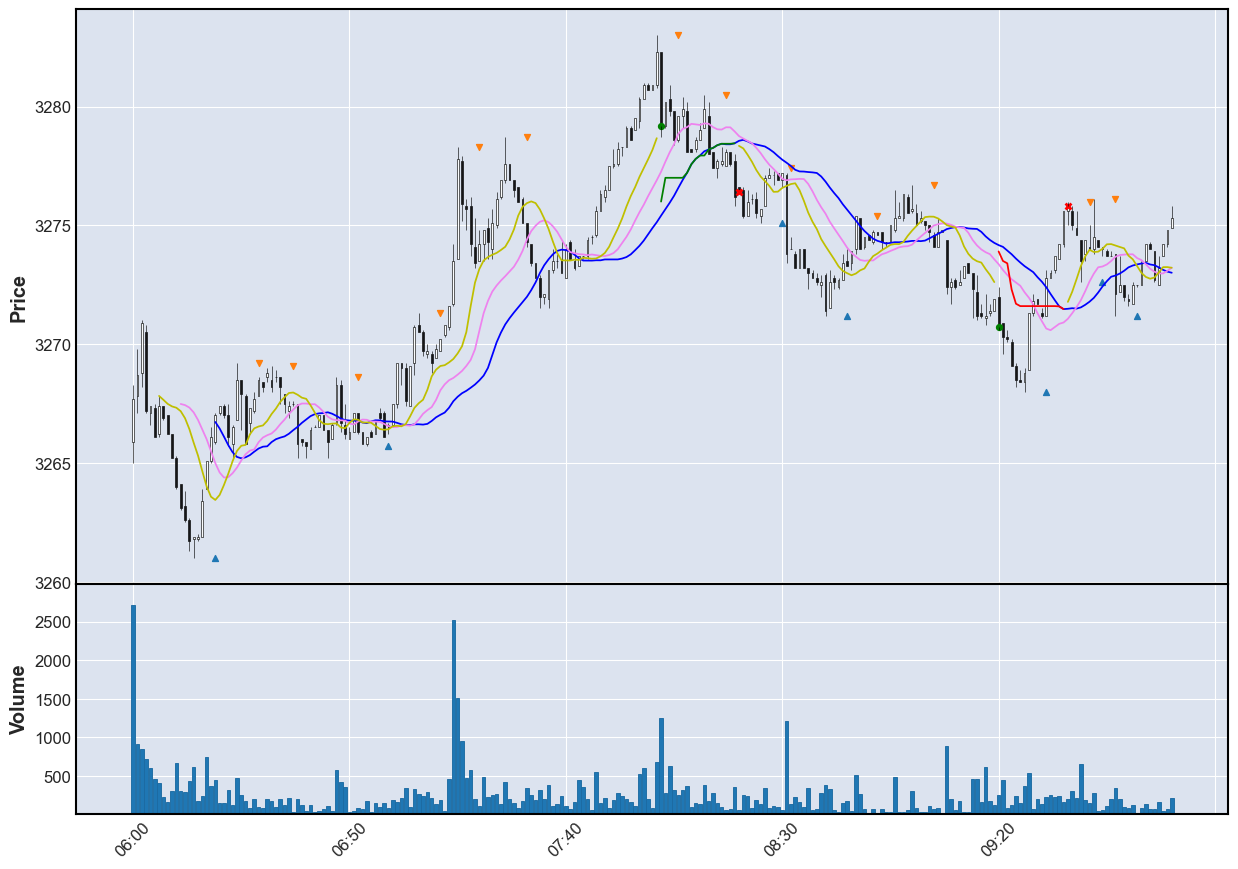

In [16]:

apds = [ mpf.make_addplot(view_data["jaw"],   color="b"),
         mpf.make_addplot(view_data["teeth"], color="violet"),
         mpf.make_addplot(view_data["fractal_bull"],   type='scatter', marker='^'),
         mpf.make_addplot(view_data["fractal_bear"],   type='scatter', marker='v'),
         mpf.make_addplot(view_data["deals_in"],       type='scatter', marker='o', color="g", ),
         mpf.make_addplot(view_data["deals_out"],      type='scatter', marker='x', color="r"),
         mpf.make_addplot(view_data["bull_stop_loss"], color="g"),
         mpf.make_addplot(view_data["bear_stop_loss"], color="r"),
         mpf.make_addplot(view_data["no_stop_loss"  ], color="y")
       ]
mpf.plot(view_data, addplot=apds, type='candle', volume=True,figscale=2)

In [17]:
plt.hist([l["value"] for l in losses ], int(np.var([l["value"] for l in losses ])*3))

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer